# NSGL : Facebook100

Le jeu de données Facebook100 constitue un snapshot du réseau social datant de septembre 2005, période durant laquelle seuls les étudiants des universités américaines y avaient accès - la plateforme ayant été lancée initialement à Harvard en février 2004 et s'étendait progressivement aux universités tout en restant fermée au grand public. Ce corpus regroupe les graphes d'amitié intra-universitaires de 100 établissements, totalisant environ 1,2 million d'utilisateurs anonymisés et près de 94 millions d'arêtes non dirigées.

Les noeuds possèdent des métadonnées (statut, genre, majeure, dortoir) mais la répartition est inégale suivant l'obligation ou non de renseigner certaines données. Aussi, le taux d'adoption varie selon les réseaux (défini par l'index d'arrivée sur Facebook). 

## Q 1 : Reading

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import glob
import pandas as pd
import math
from abc import ABC, abstractmethod
import random
import scipy.sparse as sp
from sklearn.metrics import accuracy_score
import community.community_louvain as community_louvain
from sklearn.metrics.cluster import normalized_mutual_info_score



data_path = r"C:\Users\X515\OneDrive\3. cours\5. Telecom\9. Graphs\nsgl_rendu\data"

## Q2 :  Social Network Analysis with the Facebook100 Dataset

In [12]:
def load_and_get_lcc(filename, name):
    full_path = os.path.join(data_path, filename)
    if not os.path.exists(full_path):
        print(f"Erreur: Fichier introuvable {full_path}")
        return None

    print(name)
    G = nx.read_gml(full_path)
    print(f"Nœuds originaux: {len(G)}")
    
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()
        print(f"Nœuds dans LCC: {len(G)}")
    else:
        print("Le graphe est déjà connexe.")
        
    return G

In [ ]:
graphs = {}

univ_q2 = {
    "Caltech": "Caltech36.gml", 
    "MIT": "MIT8.gml", 
    "Johns Hopkins": "Johns Hopkins55.gml" 
}

for name, filename in univ_q2.items():
    G = load_and_get_lcc(filename, name)
    if G:
        graphs[name] = G

Caltech
Nœuds originaux: 769
Nœuds dans LCC: 762
MIT
Nœuds originaux: 6440
Nœuds dans LCC: 6402
Johns Hopkins
Nœuds originaux: 5180
Nœuds dans LCC: 5157


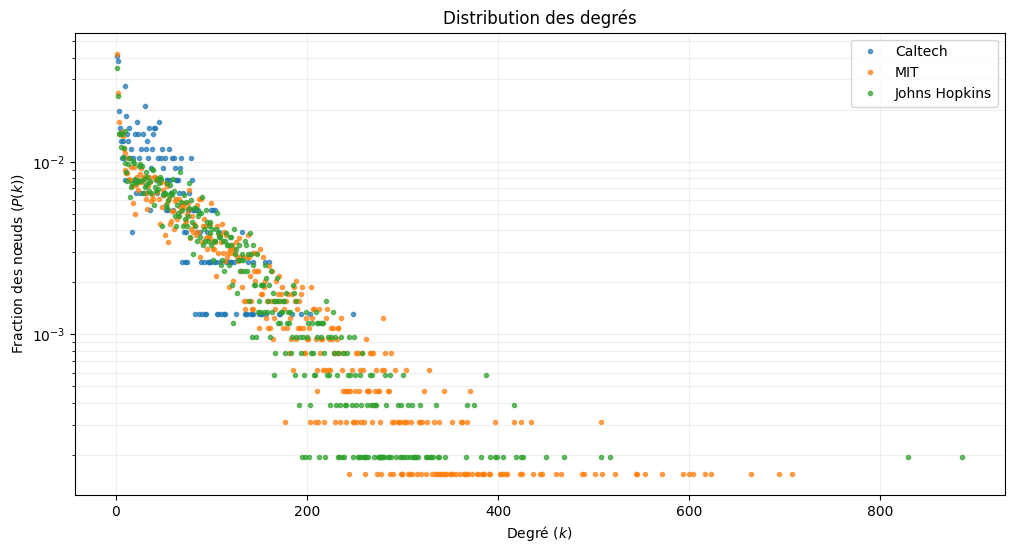

Réseau          | Nœuds      | Arêtes     | Densité    | C_glob (Trans.) | C_loc_moyen    
------------------------------------------------------------------------------------------
Caltech         | 762        | 16651      | 0.057429   | 0.291281        | 0.409117
MIT             | 6402       | 251230     | 0.012261   | 0.180288        | 0.272360
Johns Hopkins   | 5157       | 186572     | 0.014034   | 0.193161        | 0.269008
------------------------------------------------------------------------------------------


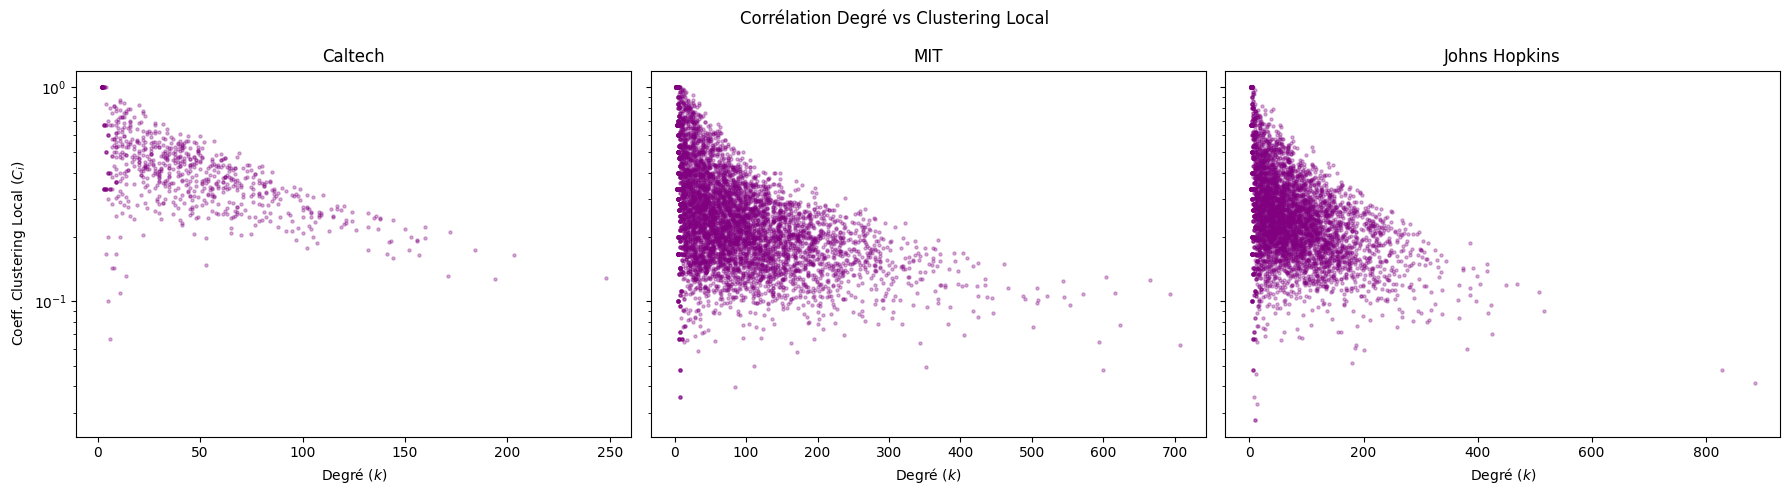

In [6]:
def analyze_networks(graphs):
    # Distribution des degrés
    plt.figure(figsize=(12, 6))
    
    for name, G in graphs.items():
        degrees = [d for n, d in G.degree()]
        degree_counts = nx.degree_histogram(G)
        degrees_range = range(len(degree_counts))
        
        x = [d for d in degrees_range if degree_counts[d] > 0]
        y = [degree_counts[d] / G.number_of_nodes() for d in x]
        
        plt.semilogy(x, y, marker='.', linestyle='None', label=name, alpha=0.7)

    plt.title("Distribution des degrés")
    plt.xlabel("Degré ($k$)")
    plt.ylabel("Fraction des nœuds ($P(k)$)")
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    # plt.savefig("q2a_degree_distribution.png") 
    plt.show()

    # Clustering & Densité
    print(f"{'Réseau':<15} | {'Nœuds':<10} | {'Arêtes':<10} | {'Densité':<10} | {'C_glob (Trans.)':<15} | {'C_loc_moyen':<15}")
    print("-" * 90)

    for name, G in graphs.items():
        n = G.number_of_nodes()
        m = G.number_of_edges()
        
        # Densité : m / (n(n-1)/2)
        density = nx.density(G)
        
        # Global Clustering (Transitivity) : 3 * triangles / triades connectées
        global_clustering = nx.transitivity(G)
        
        # Mean Local Clustering : Moyenne des coefficients de clustering locaux
        avg_local_clustering = nx.average_clustering(G)
        
        print(f"{name:<15} | {n:<10} | {m:<10} | {density:.6f}   | {global_clustering:.6f}        | {avg_local_clustering:.6f}")

    print("-" * 90)

    # Degré vs Local Clustering 
    # C(k) ~ k^-1 indique une hiérarchie.
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    
    for i, (name, G) in enumerate(graphs.items()):
        ax = axes[i]
        
        clustering_coeffs = nx.clustering(G)
        degrees = dict(G.degree())
        
        x = []
        y = []
        for node in G.nodes():
            deg = degrees[node]
            if deg > 1: # Clustering non défini pour k=0 ou 1
                x.append(deg)
                y.append(clustering_coeffs[node])
        
        ax.scatter(x, y, s=5, alpha=0.3, c='purple')
        ax.set_yscale('log')
        ax.set_title(f"{name}")
        ax.set_xlabel("Degré ($k$)")
        if i == 0:
            ax.set_ylabel("Coeff. Clustering Local ($C_i$)")
                
    plt.suptitle("Corrélation Degré vs Clustering Local")
    plt.tight_layout()
    # plt.savefig("q2c_degree_vs_clustering.png")
    plt.show()

if __name__ == "__main__":
    if graphs:
        analyze_networks(graphs)
    else:
        print("Erreur")

## Q3 :  Assortativity Analysis with the Facebook100 Dataset

In [ ]:
# génération du tableau csv des assortativités

# pattern = os.path.join(data_path, "*.gml")
# file_list = glob.glob(pattern)

# data_rows = []

# print(f"Début du traitement de {len(file_list)} graphes...")

# for filepath in file_list:
#     filename = os.path.basename(filepath)
#     network_name = os.path.splitext(filename)[0]
    
#     try:
#         # 1. Chargement et LCC
#         G_raw = nx.read_gml(filepath)
#         if not nx.is_connected(G_raw):
#             largest_cc = max(nx.connected_components(G_raw), key=len)
#             G = G_raw.subgraph(largest_cc).copy()
#         else:
#             G = G_raw
            
#         n = G.number_of_nodes()
        
#         # 2. Calcul des métriques
#         row = {
#             'network': network_name,
#             'n': n,
#             'gender': np.nan,
#             'dorm': np.nan,
#             'major': np.nan,   #  major_index 
#             'status': np.nan,  #  student_fac 
#             'degree': np.nan
#         }
        
#         # a. Degree Assortativity
#         try:
#             row['degree'] = nx.degree_assortativity_coefficient(G)
#         except:
#             pass 
            
#         # b. Attribute Assortativity
#         attr_map = {
#             'gender': 'gender',
#             'dorm': 'dorm',
#             'major': 'major_index',
#             'status': 'student_fac'
#         }
        
#         for col_name, gml_key in attr_map.items():
#             try:
#                 if gml_key in G.nodes[list(G.nodes)[0]]:
#                     row[col_name] = nx.attribute_assortativity_coefficient(G, gml_key)
#             except Exception:
#                 pass

#         data_rows.append(row)
        
#         if len(data_rows) % 10 == 0:
#             print(f"{len(data_rows)} graphes ")

#     except Exception as e:
#         print(f"Erreur : {filename}: {e}")

# # DF et auvegarde
# df = pd.DataFrame(data_rows)

# cols_order = ['network', 'n', 'gender', 'dorm', 'major', 'status', 'degree']
# df = df[cols_order]

# output_file = "facebook100_assortativity.csv"
# df.to_csv(output_file, index=False)

# print("-" * 30)
# print(f"Terminé. Fichier sauvegardé : {output_file}")
# print(df.head()) 

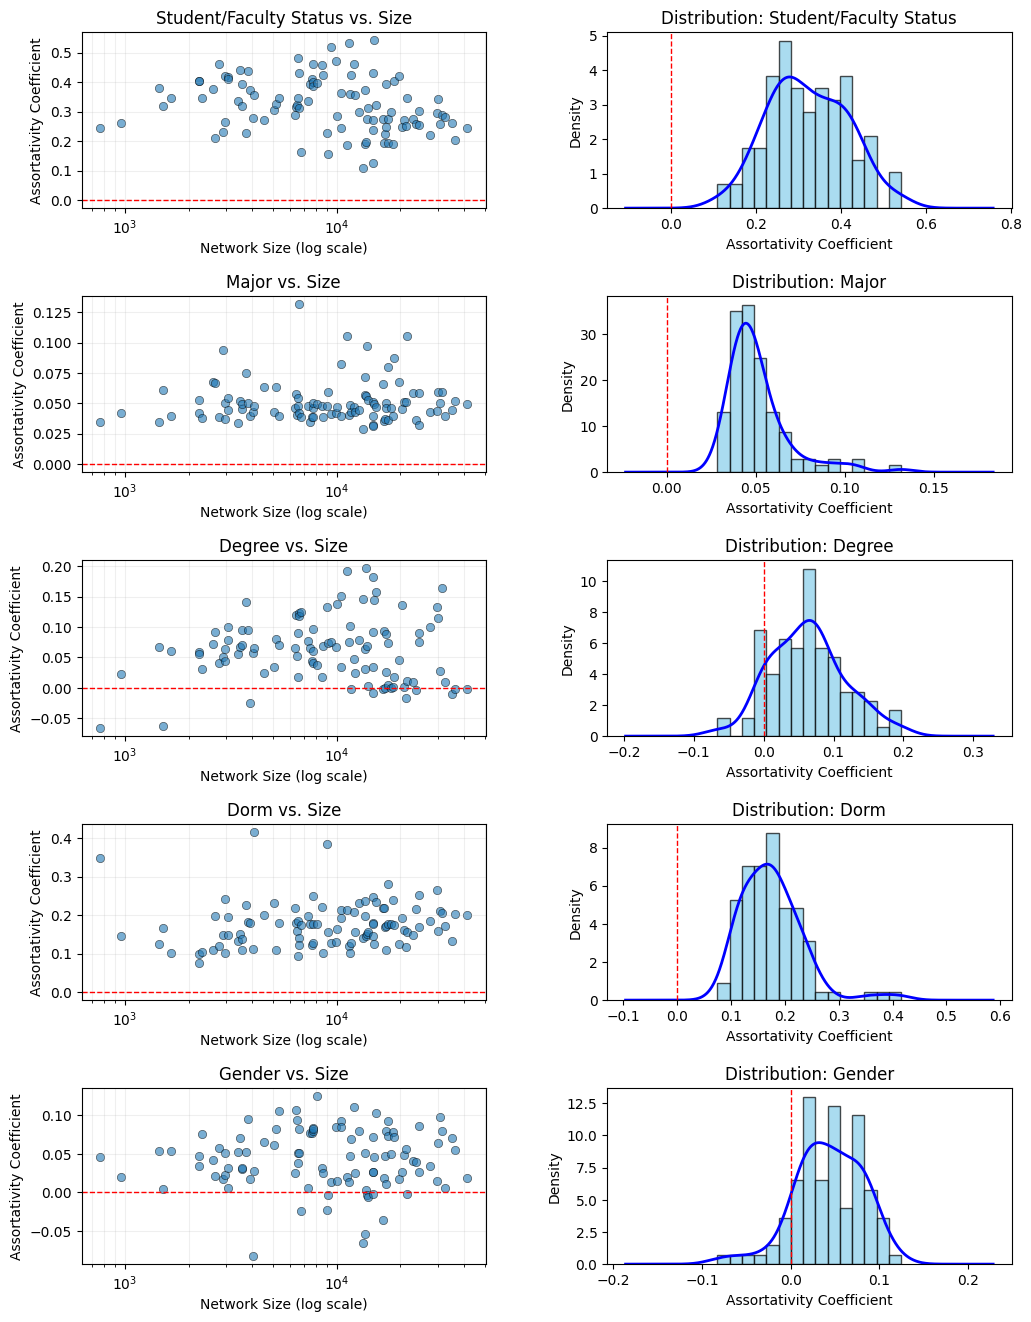


Means
status    0.322694
major     0.051107
degree    0.062609
dorm      0.175098
gender    0.042949
dtype: float64


In [ ]:
file_path = r"C:\Users\X515\OneDrive\3. cours\5. Telecom\9. Graphs\nsgl_rendu\facebook100_assortativity.csv"
df = pd.read_csv(file_path)

# sans 'network' et 'n'
attributes = ['status', 'major', 'degree', 'dorm', 'gender']
titles = {
    'status': 'Student/Faculty Status', 
    'major': 'Major', 
    'degree': 'Degree', 
    'dorm': 'Dorm', 
    'gender': 'Gender'
}

fig, axes = plt.subplots(len(attributes), 2, figsize=(12, 16))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, attr in enumerate(attributes):
    clean_data = df.dropna(subset=[attr])
    
    # 1. Scatter Plot (Assortativity vs Network Size)
    ax_scatter = axes[i, 0]
    ax_scatter.scatter(clean_data['n'], clean_data[attr], alpha=0.6, edgecolors='black', linewidth=0.5)
    ax_scatter.axhline(0, color='red', linestyle='--', linewidth=1) # no asortativity line
    ax_scatter.set_xscale('log')
    ax_scatter.set_xlabel("Network Size (log scale)")
    ax_scatter.set_ylabel("Assortativity Coefficient")
    ax_scatter.set_title(f"{titles[attr]} vs. Size")
    ax_scatter.grid(True, which="both", ls="-", alpha=0.2)
    
    # 2. Histogram / Density Plot
    ax_hist = axes[i, 1]
    ax_hist.hist(clean_data[attr], bins=15, color='skyblue', edgecolor='black', density=True, alpha=0.7)
    
    # kde
    try:
        clean_data[attr].plot.kde(ax=ax_hist, color='blue', linewidth=2)
    except:
        pass 

    ax_hist.axvline(0, color='red', linestyle='--', linewidth=1)
    ax_hist.set_xlabel("Assortativity Coefficient")
    ax_hist.set_title(f"Distribution: {titles[attr]}")
    ax_hist.set_ylabel("Density")

# Sauvegarde et affichage
# plt.savefig("q3_results_plots.png", dpi=150)
plt.show()

print("\nMeans")
print(df[attributes].mean())

## Q4 : Link prediction

In [ ]:
# Tout provient de la source 4 https://www.cs.cornell.edu/home/kleinber/link-pred.pdf

class LinkPrediction(ABC):
    def __init__(self, graph):
        self.graph = graph
        self.N = len(graph)
        self.neighbors_sets = {} 
    
    def neighbors(self, v):
        """
        Retourne la liste des voisins d'un nœud.
        """
        neighbors_list = self.graph.neighbors(v)
        return list(neighbors_list)

    @abstractmethod
    def fit(self):
        """
        Pré-calcule les sets de voisins pour accélérer les intersections.
        """
        pass
    
    @abstractmethod
    def predict_score(self, u, v):
        pass


class CommonNeighbors(LinkPrediction):
    def fit(self):
        for n in self.graph.nodes():
            self.neighbors_sets[n] = set(self.graph.neighbors(n))
        
    def predict_score(self, u, v):
        neigh_u = self.neighbors_sets.get(u, set())
        neigh_v = self.neighbors_sets.get(v, set())
        
        return len(neigh_u.intersection(neigh_v))

class Jaccard(LinkPrediction):
    def fit(self):
        for n in self.graph.nodes():
            self.neighbors_sets[n] = set(self.graph.neighbors(n))

    def predict_score(self, u, v):
        neigh_u = self.neighbors_sets.get(u, set())
        neigh_v = self.neighbors_sets.get(v, set())
        
        intersection_size = len(neigh_u.intersection(neigh_v))
        if intersection_size == 0: 
            return 0.0
            
        union_size = len(neigh_u.union(neigh_v))
        return intersection_size / union_size if union_size > 0 else 0.0

class AdamicAdar(LinkPrediction):
    def fit(self):
        for n in self.graph.nodes():
            self.neighbors_sets[n] = set(self.graph.neighbors(n))
            
        self.log_degrees = {}
        for n in self.graph.nodes():
            d = self.graph.degree(n)
            self.log_degrees[n] = 1 / math.log(d) if d > 1 else 0.0

    def predict_score(self, u, v):
        neigh_u = self.neighbors_sets.get(u, set())
        neigh_v = self.neighbors_sets.get(v, set())
        
        common = neigh_u.intersection(neigh_v)
        
        score = 0
        for w in common:
            score += self.log_degrees.get(w, 0.0) # voisin commun z connectant x et y a forcément un degré >= 2 
                
        return score

Contrairement à "Common Neighbors" qui vaut simplement $|\Gamma(x) \cap \Gamma(y)|$ (où chaque ami commun compte pour 1), Adamic/Adar pondère cette somme.Si mon ami commun est très populaire (gros degré), le terme $\frac{1}{\log(\text{degré})}$ est petit : il apporte peu d'information (c'est "facile" d'être connecté à lui).Si mon ami commun est très sélectif (petit degré), le terme est grand : c'est un lien fort qui suggère une vraie proximité.

In [ ]:
def link_prediction(G_original, PredictorClass):
    
    fractions = [0.05, 0.1, 0.15, 0.2]
    k_values = [50, 100, 200, 400]
    
    results_data = []

    for f in fractions:
        # 1. Sélection aléatoire des arêtes à retirer 
        all_edges = list(G_original.edges())
        num_remove = int(len(all_edges) * f)
        
        random.seed(42) # reproductibilité
        edges_removed = set(random.sample(all_edges, num_remove))
        
        # On normalise les arêtes retirées (u < v) pour faciliter la comparaison
        edges_removed_norm = set()
        for u, v in edges_removed:
            if u > v: edges_removed_norm.add((v, u))
            else: edges_removed_norm.add((u, v))

        # Création du graphe d'entraînement G' (G_original - edges_removed)
        G_train = G_original.copy()
        G_train.remove_edges_from(edges_removed)

        # 2. Fit du prédicteur
        predictor = PredictorClass(G_train)
        predictor.fit()

        # 3. Calcul des scores pour toutes les paires non connectées dans G_train 
        predictions = []
        nodes = list(G_train.nodes())
        
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                u, v = nodes[i], nodes[j]
                
                # On ne prédit que si l'arête n'existe pas déjà dans G_train
                # (On cherche à retrouver celles qui manquent)
                if not G_train.has_edge(u, v):
                    score = predictor.predict_score(u, v)
                    if score > 0: # Inutile de stocker les scores nuls
                        predictions.append(((u, v), score))

        # 4. Tri décroissant 
        predictions.sort(key=lambda x: x[1], reverse=True)

        # 5. Calcul Precision/Recall pour chaque k 
        for k in k_values:
            # Top-k candidats
            top_k = predictions[:k]
            
            # Intersection (True Positives) 
            hits = 0
            for (u, v), score in top_k:
                # On remet dans l'ordre u < v pour vérifier
                pair = (v, u) if u > v else (u, v)
                if pair in edges_removed_norm:
                    hits += 1
            
            # Precision = TP / (TP + FP) = hits / k
            precision = hits / k if k > 0 else 0
            
            # Recall = TP / (TP + FN) = hits / |E_removed|
            recall = hits / len(edges_removed) if len(edges_removed) > 0 else 0
            
            results_data.append({
                'Metric': PredictorClass.__name__,
                'Fraction Removed (f)': f,
                'k': k,
                'Hits': hits,
                'Precision': precision,
                'Recall': recall
            })
            
    return pd.DataFrame(results_data)

In [12]:
univs_q4 = {
    "Trinity": "Trinity100.gml", 
    "Reed": "Reed98.gml", 
    "Simmons": "Simmons81.gml",
    "Caltech": "Caltech36.gml",
    "Williams": "Williams40.gml",
    "UCLA": "UCLA26.gml",
    "Stanford": "Stanford3.gml",
    "yale": "Yale4.gml",
    "princeton": "Princeton12.gml",
    "michigan": "Michigan23.gml"
}

graphs_q4 = {}

for name, filename in univs_q4.items():
    G = load_and_get_lcc(filename, name) 
    if G:
        graphs_q4[name] = G

results_list = []
metrics = [CommonNeighbors, Jaccard, AdamicAdar]

for name, G in graphs_q4.items():
    print(f">\n > Traitement de {name} ({len(G)} noeuds)...")
    
    for MetricClass in metrics:
        try:
            df_temp = link_prediction(G, MetricClass)
            
            df_temp.insert(0, 'Network', name)
            
            results_list.append(df_temp)
            print(f"   - {MetricClass.__name__} terminé.")
            
        except Exception as e:
            print(f"   ! Erreur sur {name} / {MetricClass.__name__}: {e}")

if results_list:
    final_df = pd.concat(results_list, ignore_index=True)
    
    output_filename = "q4_results_10netwoks.csv"
    final_df.to_csv(output_filename, index=False)
    
    print("-" * 30)
    print(final_df.head())
else:
    print("Aucun résultat n'a été généré.")

Trinity
Nœuds originaux: 2613
Le graphe est déjà connexe.
Reed
Nœuds originaux: 962
Le graphe est déjà connexe.
Simmons
Nœuds originaux: 1518
Nœuds dans LCC: 1510
Caltech
Nœuds originaux: 769
Nœuds dans LCC: 762
Williams
Nœuds originaux: 2790
Nœuds dans LCC: 2788
UCLA
Nœuds originaux: 20467
Nœuds dans LCC: 20453
Stanford
Nœuds originaux: 11621
Nœuds dans LCC: 11586
yale
Nœuds originaux: 8578
Nœuds dans LCC: 8561
princeton
Nœuds originaux: 6596
Nœuds dans LCC: 6575
michigan
Nœuds originaux: 30147
Nœuds dans LCC: 30106
>
 > Traitement de Trinity (2613 noeuds)...
   - CommonNeighbors terminé.
   - Jaccard terminé.
   - AdamicAdar terminé.
>
 > Traitement de Reed (962 noeuds)...
   - CommonNeighbors terminé.
   - Jaccard terminé.
   - AdamicAdar terminé.
>
 > Traitement de Simmons (1510 noeuds)...
   - CommonNeighbors terminé.
   - Jaccard terminé.
   - AdamicAdar terminé.
>
 > Traitement de Caltech (762 noeuds)...
   - CommonNeighbors terminé.
   - Jaccard terminé.
   - AdamicAdar terminé

In [14]:
# analyse et visualisation des résultats

file_path = "q4_results_10netwoks.csv" 
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Erreur: Le fichier {file_path} est introuvable.")
    exit()

# F1-Score : Combine Précision et Recall. 
df['F1_Score'] = df.apply(lambda row: 2 * (row['Precision'] * row['Recall']) / (row['Precision'] + row['Recall']) 
                          if (row['Precision'] + row['Recall']) > 0 else 0, axis=1)

# A. Comparaison des Métriques (Moyenne Globale)
# Permet de trancher : Adamic/Adar vs Common Neighbors vs Jaccard
print("\n 1. Performance Moyenne par Métrique ")
metrics_summary = df.groupby('Metric')[['Precision', 'Recall', 'F1_Score']].mean()
print(metrics_summary.sort_values(by='Precision', ascending=False))

# B. par Réseau
print("\n 2. Performance Moyenne par Réseau ")
network_summary = df.groupby('Network')[['Precision', 'Recall', 'F1_Score']].mean()
print(network_summary.sort_values(by='Precision', ascending=False))

# C. Analyse de la Robustesse (Impact de k)
print("\n 3. Analyse de la Robustesse (Précision selon k)")
# On fait un pivot pour voir l'évolution de la précision selon k pour chaque métrique
k_pivot = df.pivot_table(index='Metric', columns='k', values='Precision', aggfunc='mean')
print(k_pivot)


 1. Performance Moyenne par Métrique 
                 Precision    Recall  F1_Score
Metric                                        
CommonNeighbors   0.644531  0.014131  0.025401
AdamicAdar        0.643844  0.014354  0.025773
Jaccard           0.297687  0.010884  0.019253

 2. Performance Moyenne par Réseau 
           Precision    Recall  F1_Score
Network                                 
Trinity     0.719219  0.010486  0.020384
UCLA        0.664427  0.001689  0.003361
princeton   0.607031  0.003714  0.007343
Williams    0.600677  0.008982  0.017453
Stanford    0.585052  0.001823  0.003624
Caltech     0.543958  0.051226  0.087331
Simmons     0.468333  0.021165  0.038943
michigan    0.391094  0.000594  0.001185
Reed        0.363958  0.030020  0.052102
yale        0.343125  0.001528  0.003030

 3. Analyse de la Robustesse (Précision selon k)
k                   50       100       200     400
Metric                                            
AdamicAdar       0.6900  0.66350  0.630375  0

## Q5 : Find missing labels with the label propagation algorithm

In [ ]:
class LabelPropagation:
    def __init__(self, graph, max_iter=100, tol=1e-3):
        self.graph = graph
        self.nodes = list(graph.nodes())
        self.node_to_idx = {n: i for i, n in enumerate(self.nodes)}
        self.N = len(self.nodes)
        self.max_iter = max_iter
        self.tol = tol
        
        # Pré-calcul de la matrice de transition T = D^-1 * A
        A = nx.adjacency_matrix(graph, nodelist=self.nodes)
        degrees = np.array(A.sum(axis=1)).flatten()
        degrees[degrees == 0] = 1 
        D_inv = sp.diags(1.0 / degrees)
        self.T = D_inv.dot(A)

    def fit_predict(self, labels_dict, missing_nodes_mask):
        
        # 1. Encodage des labels (String -> Int) basé uniquement sur ceux qu'on connait
        unique_labels = sorted(list(set(labels_dict.values())))
        label_to_id = {l: i for i, l in enumerate(unique_labels)}
        # Inverse pour le décodage final
        id_to_label = {i: l for l, i in label_to_id.items()}
        K = len(unique_labels)
        
        # 2. Construction de la matrice Y initiale (N x K)
        Y = np.zeros((self.N, K))
        
        # Indices des nœuds connus (Training set)
        known_indices = []
        known_values = [] 
        
        for i, node in enumerate(self.nodes):
            if node in labels_dict:
                lbl = labels_dict[node]
                
                if node not in missing_nodes_mask:
                    col_idx = label_to_id[lbl]
                    Y[i, col_idx] = 1.0
                    known_indices.append(i)
                    known_values.append(col_idx)
        
        known_indices = np.array(known_indices)
        
        if len(known_indices) == 0:
            print("Attention : Aucun nœud d'entraînement disponible (tout est masqué ou inconnu).")
            return {}

        # 3. Boucle de Propagation
        Y_prev = np.zeros_like(Y)
        
        for iteration in range(self.max_iter):
            # Diffusion
            Y_new = self.T.dot(Y)
            
            # Clamping (On force les nœuds connus à garder leur vraie valeur)
            Y_new[known_indices, :] = 0
            for idx, col in zip(known_indices, known_values):
                Y_new[idx, col] = 1.0
            
            # Convergence check
            if np.allclose(Y_new, Y_prev, atol=self.tol):
                Y = Y_new
                break
            Y_prev = Y_new.copy()
            Y = Y_new
            
        # 4. Décodage
        predictions = {}
        for node in missing_nodes_mask:
            # On ne prédit que si le nœud existe dans le graphe
            if node in self.node_to_idx:
                idx = self.node_to_idx[node]
                # Argmax donne l'indice de la colonne la plus forte
                pred_col = np.argmax(Y[idx, :])
                predictions[node] = id_to_label[pred_col]
            
        return predictions

def run_label_propagation_experiment(graph, attribute_name, fractions=[0.1, 0.2, 0.3]):
    # 1. Extraction de la vérité terrain pour l'attribut donné
    ground_truth = {}
    valid_nodes = []
    
    for n, data in graph.nodes(data=True):
        val = data.get(attribute_name)
        if val is not None and val != 0: # On exclut les 0 (données manquantes d'origine)
            ground_truth[n] = val
            valid_nodes.append(n)
            
    if not valid_nodes:
        print(f"Attribut {attribute_name} vide ou invalide.")
        return []

    print(f"Attribut: {attribute_name} ({len(valid_nodes)} nœuds valides)")
    
    lp = LabelPropagation(graph)
    results = []

    for f in fractions:
        # Sélection aléatoire des nœuds à masquer (Test Set)
        num_to_remove = int(len(valid_nodes) * f)
        random.seed(42) # Reproductibilité
        missing_nodes = set(random.sample(valid_nodes, num_to_remove))
        
        # Prédiction
        preds = lp.fit_predict(ground_truth, missing_nodes)
        
        # Évaluation (Accuracy)
        y_true = [ground_truth[n] for n in missing_nodes]
        y_pred = [preds[n] for n in missing_nodes]
        
        acc = accuracy_score(y_true, y_pred)
        
        print(f"  Fraction removed {f}: Accuracy = {acc:.4f}")
        
        results.append({
            "Attribute": attribute_name,
            "Fraction Removed": f,
            "Accuracy": acc
        })
        
    return results

In [20]:
for name, G in graphs_q4.items():
    print(f"\n traitement de {name}")
    G_target = graphs_q4[name]
    
    all_results = []
    for attr in ['dorm', 'major_index', 'gender']:
        res = run_label_propagation_experiment(G_target, attr)
        all_results.extend(res)
        
    df_q5 = pd.DataFrame(all_results)
    print(f"\n tableu recap pour {name}")
    print(df_q5)


 traitement de Trinity
Attribut: dorm (1749 nœuds valides)
  Fraction removed 0.1: Accuracy = 0.4023
  Fraction removed 0.2: Accuracy = 0.3754
  Fraction removed 0.3: Accuracy = 0.3874
Attribut: major_index (1917 nœuds valides)
  Fraction removed 0.1: Accuracy = 0.2827
  Fraction removed 0.2: Accuracy = 0.2533
  Fraction removed 0.3: Accuracy = 0.2417
Attribut: gender (2374 nœuds valides)
  Fraction removed 0.1: Accuracy = 0.6287
  Fraction removed 0.2: Accuracy = 0.6308
  Fraction removed 0.3: Accuracy = 0.6292

 Tableau Récapitulatif Q5 :
     Attribute  Fraction Removed  Accuracy
0         dorm               0.1  0.402299
1         dorm               0.2  0.375358
2         dorm               0.3  0.387405
3  major_index               0.1  0.282723
4  major_index               0.2  0.253264
5  major_index               0.3  0.241739
6       gender               0.1  0.628692
7       gender               0.2  0.630802
8       gender               0.3  0.629213

 traitement de Reed
A

C:\Users\X515\AppData\Local\Temp\ipykernel_19136\1222142001.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attribute', y='Accuracy', data=df_melted, ax=axes[1], palette="Set2")


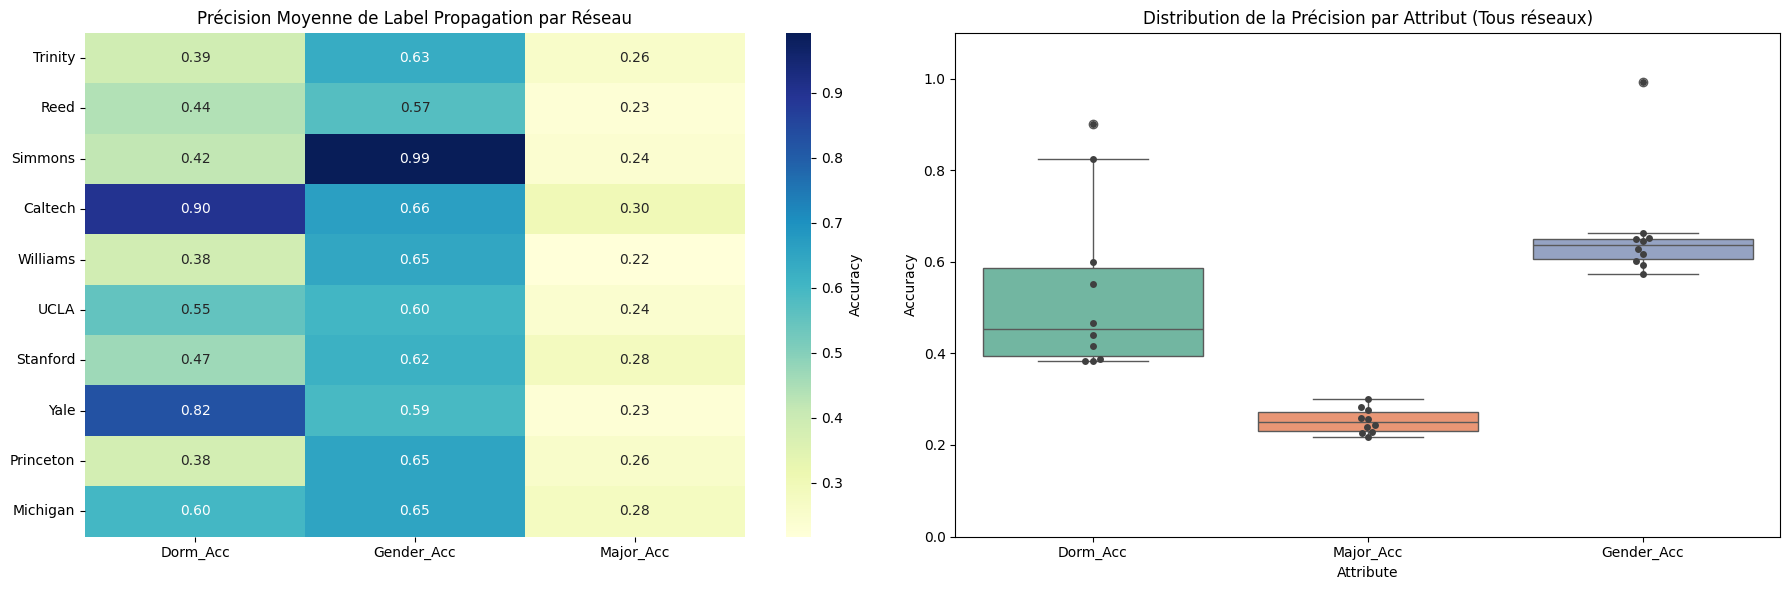

In [21]:
# visu plus sympa

data = {
    'Network': ['Trinity', 'Reed', 'Simmons', 'Caltech', 'Williams', 'UCLA', 'Stanford', 'Yale', 'Princeton', 'Michigan'],
    'Dorm_Acc': [0.388, 0.441, 0.417, 0.900, 0.384, 0.551, 0.467, 0.825, 0.383, 0.599], 
    'Major_Acc': [0.259, 0.227, 0.239, 0.300, 0.217, 0.243, 0.283, 0.229, 0.256, 0.277],
    'Gender_Acc': [0.629, 0.574, 0.992, 0.663, 0.645, 0.602, 0.618, 0.594, 0.651, 0.650]
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars='Network', var_name='Attribute', value_name='Accuracy')

# Configuration de la figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. HEATMAP (Précision par Université et Attribut)
# On pivote pour avoir une matrice
heatmap_data = df.set_index('Network')[['Dorm_Acc', 'Gender_Acc', 'Major_Acc']]
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f", ax=axes[0], cbar_kws={'label': 'Accuracy'})
axes[0].set_title('Précision Moyenne de Label Propagation par Réseau')
axes[0].set_ylabel('')

# 2. BOXPLOT (Distribution globale par attribut)
sns.boxplot(x='Attribute', y='Accuracy', data=df_melted, ax=axes[1], palette="Set2")
sns.swarmplot(x='Attribute', y='Accuracy', data=df_melted, color=".25", ax=axes[1]) # Montre les points individuels
axes[1].set_title('Distribution de la Précision par Attribut (Tous réseaux)')
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig("q5_synthesis_plots.png")
plt.show()

In [ ]:

G = graphs_q6['Caltech']

# 1. Récupération des attributs "Dorm" pour la couleur
# On crée une liste de couleurs : chaque valeur de dortoir aura une couleur unique
dorms = [G.nodes[n]['dorm'] for n in G.nodes()]
unique_dorms = list(set(dorms))
dorm_to_int = {d: i for i, d in enumerate(unique_dorms)}
node_colors = [dorm_to_int[d] for d in dorms]

# 2. Calcul de la position (Layout)
# Spring layout est bien, mais pour voir les clusters, on augmente 'k' (distance optimale)
# iterations=50 pour laisser le temps de se stabiliser
print("Calcul du layout en cours (ça peut prendre quelques secondes)...")
pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42) 

# 3. Affichage
plt.figure(figsize=(12, 12)) # Grand carré
nx.draw_networkx_nodes(
    G, pos, 
    node_size=50,       # Taille des points (pas trop gros)
    cmap=plt.cm.tab10,  # Palette de couleurs distinctes (tab10 ou Set1)
    node_color=node_colors, 
    alpha=0.9           # Légère transparence
)
# On dessine les arêtes très fines et transparentes pour ne pas gâcher la vue
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5, edge_color='gray')

plt.title("Visualisation du réseau Caltech (Coloration par Dortoir)", fontsize=16)
plt.axis('off') # On enlève les axes X/Y moches
plt.tight_layout()
plt.savefig("caltech_dorm_viz.png", dpi=300)
plt.show()

## Q6 : community

on a du installer community.community_louvain et donc redémarrer le kernel et recharger les graphes

In [13]:
univs_q6 = {
    "Trinity": "Trinity100.gml", 
    "Reed": "Reed98.gml", 
    "Simmons": "Simmons81.gml",
    "Caltech": "Caltech36.gml",
    "Williams": "Williams40.gml",
    "UCLA": "UCLA26.gml",
    "Stanford": "Stanford3.gml",
    "yale": "Yale4.gml",
    "princeton": "Princeton12.gml",
    "michigan": "Michigan23.gml"
}

graphs_q6 = {}

for name, filename in univs_q6.items():
    G = load_and_get_lcc(filename, name) 
    if G:
        graphs_q6[name] = G

Trinity
Nœuds originaux: 2613
Le graphe est déjà connexe.
Reed
Nœuds originaux: 962
Le graphe est déjà connexe.
Simmons
Nœuds originaux: 1518
Nœuds dans LCC: 1510
Caltech
Nœuds originaux: 769
Nœuds dans LCC: 762
Williams
Nœuds originaux: 2790
Nœuds dans LCC: 2788
UCLA
Nœuds originaux: 20467
Nœuds dans LCC: 20453
Stanford
Nœuds originaux: 11621
Nœuds dans LCC: 11586
yale
Nœuds originaux: 8578
Nœuds dans LCC: 8561
princeton
Nœuds originaux: 6596
Nœuds dans LCC: 6575
michigan
Nœuds originaux: 30147
Nœuds dans LCC: 30106


In [ ]:
attributes_to_test = {
    'Dorm': 'dorm', 
    'Major': 'major_index', 
    'Year': 'year',
    'Status': 'student_fac',
    'Gender': 'gender'
}

results_q6_list = []

for name, G in graphs_q6.items():
    print(f"\n Louvain : {name} ({len(G)} noeuds)...")

    # Détection Louvain (Basée sur les liens)
    partition_louvain = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition_louvain, G)
    
    nodes_list = list(G.nodes())
    labels_pred = [partition_louvain[n] for n in nodes_list]
    num_communities = len(set(labels_pred)) # nomre de communautés détectées
    
    print(f" Mod: {modularity:.3f}, Comms: {num_communities})")

    # Comparaison NMI avec Attributs
    for attr_name, attr_key in attributes_to_test.items():
        labels_true = []
        for n in nodes_list:
            val = G.nodes[n].get(attr_key, 0)
            labels_true.append(val)
        
        nmi = normalized_mutual_info_score(labels_true, labels_pred)
        
        results_q6_list.append({
            'Network': name,
            'Attribute': attr_name,
            'NMI': nmi,
            'Modularity': modularity,
            'Num_Communities': num_communities
        })

if results_q6_list:
    df_q6 = pd.DataFrame(results_q6_list)
    df_q6.to_csv("q6_results_communities.csv", index=False)
    
    print("\n Tableau Croisé des NMI par réseau et attribut \n")
    print(df_q6.pivot(index='Network', columns='Attribute', values='NMI'))
else:
    print("Aucun résultat.")


 Louvain : Trinity (2613 noeuds)...
 Mod: 0.452, Comms: 7)

 Louvain : Reed (962 noeuds)...
 Mod: 0.321, Comms: 6)

 Louvain : Simmons (1510 noeuds)...
 Mod: 0.479, Comms: 7)

 Louvain : Caltech (762 noeuds)...
 Mod: 0.398, Comms: 8)

 Louvain : Williams (2788 noeuds)...
 Mod: 0.434, Comms: 7)

 Louvain : UCLA (20453 noeuds)...
 Mod: 0.440, Comms: 11)

 Louvain : Stanford (11586 noeuds)...
 Mod: 0.412, Comms: 10)

 Louvain : yale (8561 noeuds)...
 Mod: 0.424, Comms: 12)

 Louvain : princeton (6575 noeuds)...
 Mod: 0.450, Comms: 11)

 Louvain : michigan (30106 noeuds)...
 Mod: 0.463, Comms: 13)

 Tableau Croisé des NMI par réseau et attribut 

Attribute      Dorm    Gender     Major    Status      Year
Network                                                    
Caltech    0.530666  0.014510  0.069466  0.035984  0.089290
Reed       0.169065  0.019219  0.064179  0.145801  0.360455
Simmons    0.212244  0.019113  0.062339  0.166281  0.548951
Stanford   0.184222  0.012711  0.062627  0.18286

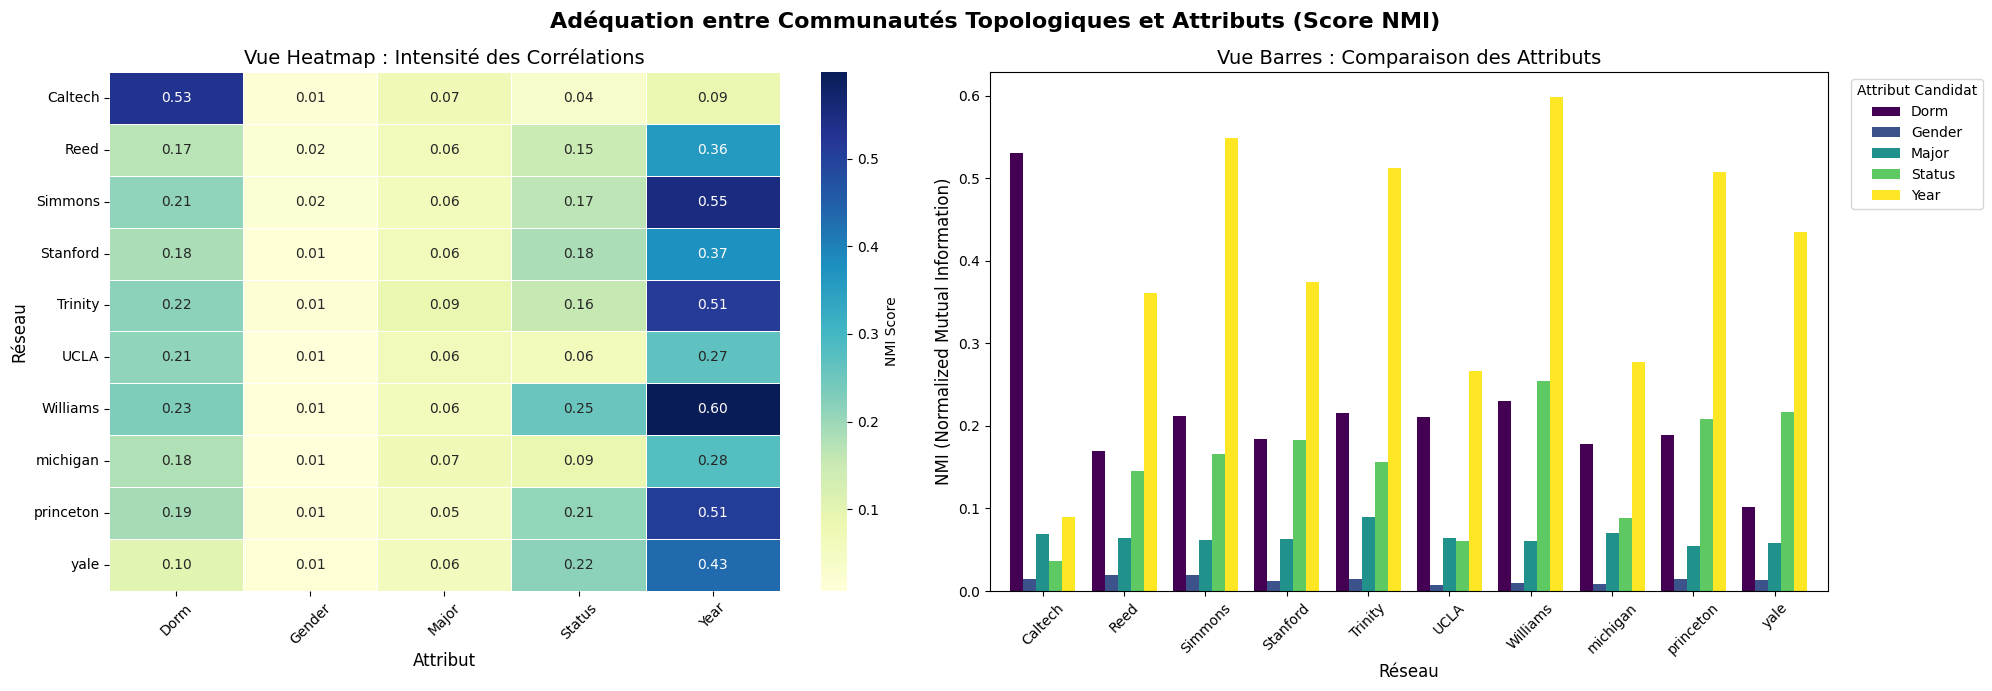

In [ ]:
# visu plus sympa

pivot_df = df_q6.pivot(index='Network', columns='Attribute', values='NMI')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# heatmap
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5, ax=axes[0], cbar_kws={'label': 'NMI Score'})

axes[0].set_title("Vue Heatmap : Intensité des Corrélations", fontsize=14)
axes[0].set_ylabel("Réseau", fontsize=12)
axes[0].set_xlabel("Attribut", fontsize=12)
axes[0].tick_params(axis='x', rotation=45) # Rotation labels x
axes[0].tick_params(axis='y', rotation=0)  # Rotation labels y

# bar plot
pivot_df.plot(kind='bar', 
              colormap='viridis', 
              ax=axes[1], 
              width=0.8)

axes[1].set_title("Vue Barres : Comparaison des Attributs", fontsize=14)
axes[1].set_ylabel("NMI (Normalized Mutual Information)", fontsize=12)
axes[1].set_xlabel("Réseau", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

axes[1].legend(title="Attribut Candidat", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.suptitle("Adéquation entre Communautés Topologiques et Attributs (Score NMI)", fontsize=16, weight='bold')
plt.tight_layout() 
plt.savefig("q6_combined_analysis.png", dpi=300)
plt.show()

Calcul du layout...


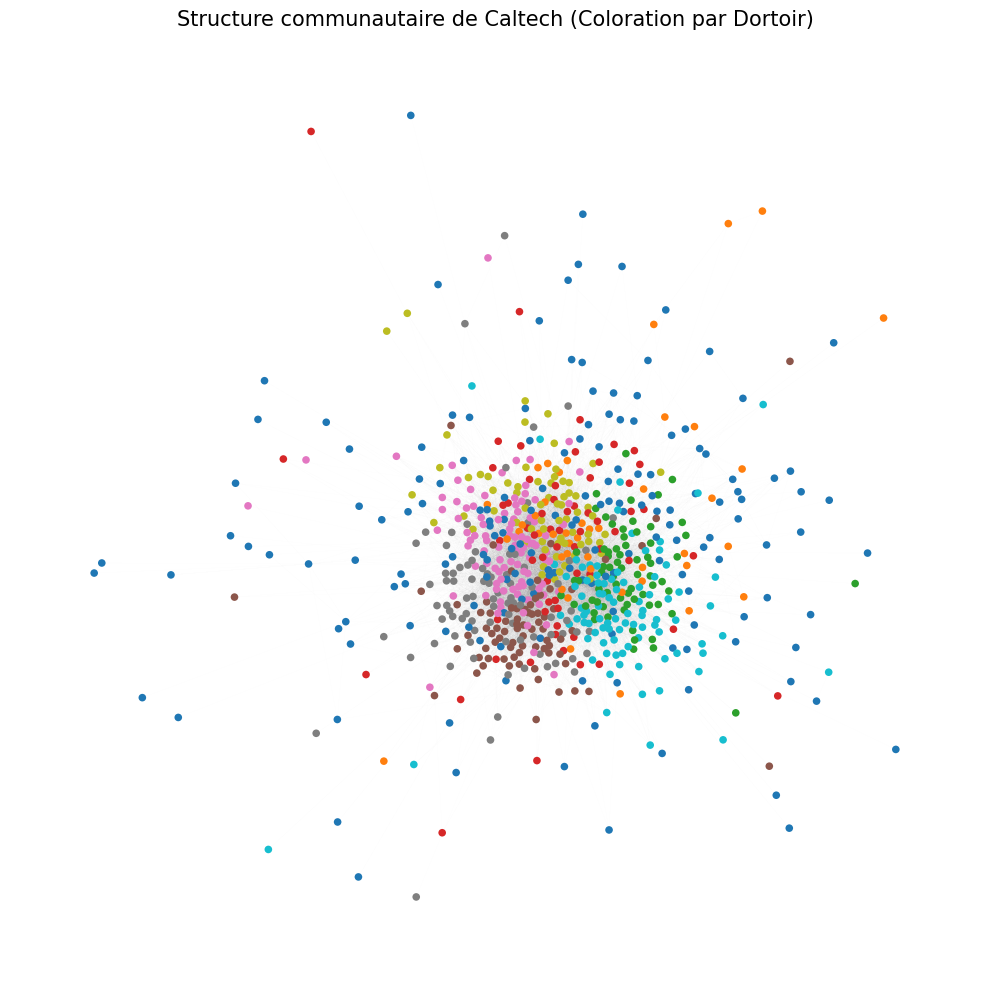

In [ ]:
# visu caltech
G = graphs_q6['Caltech']

dorms = [G.nodes[n]['dorm'] for n in G.nodes()]
unique_dorms = list(set(dorms))
dorm_to_int = {d: i for i, d in enumerate(unique_dorms)}
node_colors = [dorm_to_int[d] for d in dorms]

# k=0.25 (plus grand = plus écarté), iterations=100 (plus long = plus stable)
print("Calcul du layout...")
pos = nx.spring_layout(G, k=0.25, iterations=100, seed=42)

plt.figure(figsize=(10, 10))

nx.draw_networkx_nodes(
    G, pos, 
    node_size=30,           
    cmap=plt.cm.tab10,      
    node_color=node_colors, 
    alpha=1.0,              
    linewidths=0            
)

## arêtes très fines et claires
nx.draw_networkx_edges(G, pos, alpha=0.03, width=0.2, edge_color='gray')

plt.title("Structure communautaire de Caltech (Coloration par Dortoir)", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.savefig("caltech_viz_clean.png", dpi=300)
plt.show()